In [1]:
%%capture
!pip install sagemaker==1.72.0

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

<h2>Trading Strategy</h2>

Now that we have the predicted price for a given time period, we can build a portfolio at each time step so that we can have an idea how much profit can be generated by using the SMA prediction model. The strategy employed to build the portfolio will be standardized accross all the different prediction model we will explore later as well.

The strategy will be to invest in the top $n$ coins with the highest expected ROI and then sell it the following day. To simplify the calculation, we will be ignoring the transaction cost.

We will be trading for 1 year from April 24, 2017 and April 24, 2018.

In [3]:
def update_mean(mean, t, new_value):
    if t == 0:
        return new_value
    else:
        return (mean * (t - 1) + new_value) / t

# Function to update standard deviation based on new value
def update_std(std, mean, new_mean, t, new_value):
    if t == 0:
        return 0
    else:
        return np.sqrt((std ** 2 * (t - 1) + (new_value - new_mean) * (new_value - mean)) / t)

In [4]:
import pandas as pd
import numpy as np

def update_mean(mean, t, new_value):
    if t == 0:
        return new_value
    else:
        return (mean * (t - 1) + new_value) / t

# Function to update standard deviation based on new value
def update_std(std, mean, new_mean, t, new_value):
    if t == 0:
        return 0
    else:
        return np.sqrt((std ** 2 * (t - 1) + (new_value - new_mean) * (new_value - mean)) / t)

# Function to execute the trading strategy over the trading horizon using asset matrix
def evaluate(result, target, n=10, initial_value=10000):
    total_value = initial_value
    mean_roi = 0
    std_roi = 0

    dates = list(set(result.time))
    dates.sort()
    
    history = {}
    
    df = result.copy()
    if target == 'price':
        df['predicted_roi'] = (df['pred']/df['price_lag_1']) - 1
    else:
        df['predicted_roi'] = df['pred']
    df.sort_values(by='predicted_roi', ascending=False, inplace=True)
    
    t = 1

    for date in dates:
        temp_df = df.query('time == @date & predicted_roi > 0')

        if not temp_df.empty:
            top_n = temp_df.nlargest(n, 'predicted_roi')
            selected_n = len(top_n)
            currencies = list(top_n.sym)
            day_return = sum(top_n['roi'] * total_value / selected_n)
            day_roi = day_return/total_value
        else:
            currencies = []
            day_return = 0
            day_roi = 0
        
        total_value += day_return
        percent_returns = (total_value/initial_value - 1) * 100

        prev_mean_roi = mean_roi
        mean_roi = update_mean(prev_mean_roi, t, day_roi)
        std_roi = update_std(std_roi, prev_mean_roi, mean_roi, t, day_roi)
        std_roi = 0.001 if (std_roi == 0) else std_roi
        sharpe_ratio = mean_roi/std_roi
        
        history[date] = [total_value, day_roi, currencies, percent_returns, sharpe_ratio]

        t += 1
        
    print('Cumulative Returns: {:.2e}%, Sharpe Ratio : {:.4e}' \
                          .format(percent_returns, sharpe_ratio))
    
    history = pd.DataFrame.from_dict(history, orient='index', 
                                     columns=['total', 'roi', 'currencies', '%return', 'sharpe'])
    
    return history

In [5]:
import source.load
from source.load import *
from source import create

data_dict = source.load.load_data()
data = data_dict['data']
symbols = data_dict['symbols']

In [6]:
data

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi
27998,944816.0,Synereo,0.003485,AMP,2015-12-16,4.0,33,0.000124,1,-0.210646
27999,643767.0,Synereo,0.004415,AMP,2015-12-17,20.0,48,0.000087,2,0.259629
28000,815448.0,Synereo,0.003505,AMP,2015-12-18,34.0,38,0.000110,3,-0.110180
28001,647622.0,Synereo,0.003939,AMP,2015-12-19,222.0,50,0.000086,4,-0.063481
28002,727785.0,Synereo,0.004206,AMP,2015-12-20,13.0,40,0.000097,5,0.011787
...,...,...,...,...,...,...,...,...,...,...
670820,1087180.0,Zetacoin,0.006791,ZET,2018-04-08,2454.0,765,0.000004,1671,0.209224
670821,1141790.0,Zetacoin,0.005616,ZET,2018-04-09,1067.0,756,0.000004,1672,-0.010048
670822,943582.0,Zetacoin,0.005673,ZET,2018-04-10,9888.0,780,0.000004,1673,0.072198
670823,953339.0,Zetacoin,0.005291,ZET,2018-04-11,6207.0,779,0.000004,1674,-0.129340


<h2> Evaluating SMA Strategy </h2>

In [7]:
sets = create.load_sets(data, 'price', W=7)

In [12]:
result = sets['test']['ori']
result['pred'] = result['price_mean']
result.set_index('time', drop=True, inplace=True)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [9]:
result

,market_cap,name,price,sym,time,volume,rank,market_share,age,roi,...,roi_lag_1,roi_lag_2,roi_lag_3,roi_lag_4,roi_lag_5,roi_lag_6,roi_lag_7,roi_mean,roi_std,pred
28491,8014400.0,Synereo,0.096706,AMP,2017-04-25,125241.0,60,0.000263,497,-0.032785,...,0.007269,0.021497,0.047486,0.021568,-0.040939,0.067383,0.024909,0.021311,0.031380,0.104349
28492,7957810.0,Synereo,0.099984,AMP,2017-04-26,125740.0,63,0.000258,498,-0.115616,...,-0.032785,0.007269,0.021497,0.047486,0.021568,-0.040939,0.067383,0.013069,0.036510,0.102205
28493,8229500.0,Synereo,0.113055,AMP,2017-04-27,355183.0,62,0.000261,499,0.034819,...,-0.115616,-0.032785,0.007269,0.021497,0.047486,0.021568,-0.040939,-0.013074,0.050929,0.100918
28494,9244050.0,Synereo,0.109251,AMP,2017-04-28,211446.0,59,0.000278,500,-0.079464,...,0.034819,-0.115616,-0.032785,0.007269,0.021497,0.047486,0.021568,-0.002252,0.051898,0.102480
28495,8995880.0,Synereo,0.118682,AMP,2017-04-29,205368.0,61,0.000260,501,0.028520,...,-0.079464,0.034819,-0.115616,-0.032785,0.007269,0.021497,0.047486,-0.016685,0.057059,0.102877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670819,1024690.0,Zetacoin,0.006471,ZET,2018-04-07,888.0,766,0.000004,1670,-0.047121,...,-0.057642,0.037061,0.070367,-0.010784,-0.049134,-0.028271,-0.009051,-0.006779,0.042657,0.006367
670820,1087180.0,Zetacoin,0.006791,ZET,2018-04-08,2454.0,765,0.000004,1671,0.209224,...,-0.047121,-0.057642,0.037061,0.070367,-0.010784,-0.049134,-0.028271,-0.012218,0.044965,0.006416
670821,1141790.0,Zetacoin,0.005616,ZET,2018-04-09,1067.0,756,0.000004,1672,-0.010048,...,0.209224,-0.047121,-0.057642,0.037061,0.070367,-0.010784,-0.049134,0.021710,0.088539,0.006502
670822,943582.0,Zetacoin,0.005673,ZET,2018-04-10,9888.0,780,0.000004,1673,0.072198,...,-0.010048,0.209224,-0.047121,-0.057642,0.037061,0.070367,-0.010784,0.027294,0.085059,0.006395


In [10]:
!pygmentize './source/metric.py'

import pandas as pd
import numpy as np

def update_mean(mean, t, new_value):
    if t == 0:
        return new_value
    else:
        return (mean * (t - 1) + new_value) / t

# Function to update standard deviation based on new value
def update_std(std, mean, new_mean, t, new_value):
    if t == 0:
        return 0
    else:
        return np.sqrt((std ** 2 * (t - 1) + (new_value - new_mean) * (new_value - mean)) / t)

# Function to execute the trading strategy over the trading horizon using asset matrix
def evaluate(result, target, n=10, initial_value=10000):
    total_value = initial_value
    mean_roi = 0
    std_roi = 0

    dates = list(set(result.index))
    dates.sort()
    
    history = {}
    
    df = result.copy()
    if target == 'price':
        df['predicted_roi'] = (df['pred']/df['price_lag_1']) - 1
    else:
        df['predicted_roi'] = df['pred']
    df.sort_values(by='predicted_roi', ascending=False, inplace=True)
    
    t = 1

    for date in dates:
        temp

In [13]:
from source import metric
hist = metric.trade(result, 'price')

Cumulative Returns: 2.63e+03%, Sharpe Ratio : 1.1993e-01


In [14]:
hist

,total,roi,currencies,%return,sharpe
2017-04-25,10046.032319,0.004603,"[RVR, VOX, AMP, BTCD, WDC, XPY, XMR, CREVA, FT...",0.460323,4.603232
2017-04-26,9583.154874,-0.046076,"[RVR, VOX, AMP, BTCD, XPY, VRC, XMR, STEEM, VT...",-4.168451,-0.818019
2017-04-27,8940.917415,-0.067017,"[XPY, RVR, VOX, BTCD, XMR, AMP, USNBT, XCP]",-10.590826,-1.202520
2017-04-28,8997.689776,0.006350,"[RVR, VOX, DCR, BTCD, USNBT]",-10.023102,-0.800646
2017-04-29,8949.513065,-0.005354,"[DCR, LTC]",-10.504869,-0.725184
...,...,...,...,...,...
2018-04-07,303084.332466,-0.103197,"[CREVA, USNBT, RVR, AMP, BTCD, XLM, XMR, XPM, ...",2930.843325,0.122614
2018-04-08,314670.174748,0.038226,"[CREVA, USNBT, XPM, RVR, MEC, QRK, XLM, AMP, B...",3046.701747,0.123177
2018-04-09,297732.811890,-0.053826,"[CREVA, XPY, MEC, BTCD, WDC, AUR, LTC, XLM, XRP]",2877.328119,0.121916
2018-04-10,310311.704573,0.042249,"[MEC, XPY, ZET, WDC, BTCD, VTC, XLM, AUR, LTC,...",3003.117046,0.122555


<h2> Plotting Routines </h2>

In [15]:
def plot_history(array, scale='log', figsize=(10,5), dpi=100):
    plt.figure(figsize=figsize, dpi=dpi)
    
    for key in array:
        array[key]['total'].plot(label=key, lw=0.8)

    plt.yscale(scale)
    plt.legend()
    plt.show()

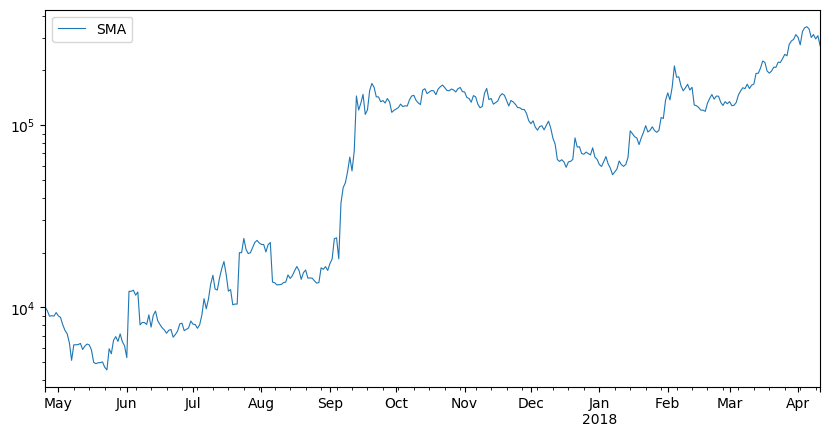

In [16]:
plot_history({'SMA': hist}, scale='log')

In [19]:
result

,market_cap,name,price,sym,volume,rank,market_share,age,roi,market_cap_lag_1,...,roi_lag_1,roi_lag_2,roi_lag_3,roi_lag_4,roi_lag_5,roi_lag_6,roi_lag_7,roi_mean,roi_std,pred
time,,,,,,,,,,,,,,,,,,,,,
2017-04-25,8014400.0,Synereo,0.096706,AMP,125241.0,60,0.000263,497,-0.032785,8209450.0,...,0.007269,0.021497,0.047486,0.021568,-0.040939,0.067383,0.024909,0.021311,0.031380,0.104349
2017-04-26,7957810.0,Synereo,0.099984,AMP,125740.0,63,0.000258,498,-0.115616,8014400.0,...,-0.032785,0.007269,0.021497,0.047486,0.021568,-0.040939,0.067383,0.013069,0.036510,0.102205
2017-04-27,8229500.0,Synereo,0.113055,AMP,355183.0,62,0.000261,499,0.034819,7957810.0,...,-0.115616,-0.032785,0.007269,0.021497,0.047486,0.021568,-0.040939,-0.013074,0.050929,0.100918
2017-04-28,9244050.0,Synereo,0.109251,AMP,211446.0,59,0.000278,500,-0.079464,8229500.0,...,0.034819,-0.115616,-0.032785,0.007269,0.021497,0.047486,0.021568,-0.002252,0.051898,0.102480
2017-04-29,8995880.0,Synereo,0.118682,AMP,205368.0,61,0.000260,501,0.028520,9244050.0,...,-0.079464,0.034819,-0.115616,-0.032785,0.007269,0.021497,0.047486,-0.016685,0.057059,0.102877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-07,1024690.0,Zetacoin,0.006471,ZET,888.0,766,0.000004,1670,-0.047121,1056070.0,...,-0.057642,0.037061,0.070367,-0.010784,-0.049134,-0.028271,-0.009051,-0.006779,0.042657,0.006367
2018-04-08,1087180.0,Zetacoin,0.006791,ZET,2454.0,765,0.000004,1671,0.209224,1024690.0,...,-0.047121,-0.057642,0.037061,0.070367,-0.010784,-0.049134,-0.028271,-0.012218,0.044965,0.006416
2018-04-09,1141790.0,Zetacoin,0.005616,ZET,1067.0,756,0.000004,1672,-0.010048,1087180.0,...,0.209224,-0.047121,-0.057642,0.037061,0.070367,-0.010784,-0.049134,0.021710,0.088539,0.006502


In [24]:
print('RMSE: ', metric.RMSE(result))

AttributeError: module 'source' has no attribute 'metric'